<a href="https://colab.research.google.com/github/IvanUlloa098/simulacion/blob/main/examen_final/EXAMEN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import simpy
import random
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
LUGARES_DESTINO = ['GUAYAQUIL', 'QUITO', 'CUENCA', 'PORTOVIEJO','MACHALA', 'AMBATO']
PESOS_LUG_DES = (30, 20, 20, 15, 10, 5)
POBL_FEM = 0.53
PROB_MAS = 0.47
MEDIA_EDAD = 35
MEDIA_COMPRA = 10
DESVIACION_COMPRA = 2
MEDIA_VIAJE = 6 * 60
DESVIACION_VIAJE = 4 * 60
CAPACIDAD_BUS = 40
LLEGADA = 10
NUM_BUSES = 5

DIAS = 7
TIEMPO_SIMULACION = DIAS * 24 * 60

bernoulli = stats.bernoulli(POBL_FEM)
distribucion = bernoulli.rvs(100) # Universo arbitrario

In [ ]:
def escoger_lugar():
  return random.choices(LUGARES_DESTINO, weights=PESOS_LUG_DES, k=1)[0]

def generar_sexo():
    poblacion=stats.bernoulli(PROB_MAS)
    if poblacion.rvs(1)[0] == 1:
      return 'M'
    else:
      return 'F'

def generar_edad():
  return np.random.poisson(MEDIA_EDAD, 1)[0]

def tiempo_compra():
    return abs(random.normalvariate(MEDIA_COMPRA, DESVIACION_COMPRA))

def tiempo_viaje():
    return abs(random.normalvariate(MEDIA_VIAJE, DESVIACION_VIAJE))

def num_boletos():
  return random.randint(1,6)

In [ ]:
class AgenciaTurismo():
    
    def __init__(self, environment, nombre):
        self.env = environment
        self.bus = simpy.Resource(self.env, capacity=CAPACIDAD_BUS+1) # mas uno para realizar una peticion como conductor
        self.nombre = nombre
        self.capacidad = CAPACIDAD_BUS
        self.con_ticket = 0
        self.accion = env.process(self.run())
        self.traveling=False
    
    def comprar_ticket(self, cliente, tickets):
        yield self.env.timeout(tiempo_compra())
        if self.capacidad < tickets: 
          print(f'BOLETOS AGOTADOS para el cliente {cliente} compra {self.capacidad} boletos. TIEMPO={self.env.now}')
          tickets = self.capacidad
          self.capacidad = 0          
          return tickets

        if self.traveling == False:        
          self.capacidad -= tickets
          self.con_ticket +=1
          print(f'Cliente {cliente} compra {tickets} boletos {self.env.now}')
          return tickets
        
        return 0

    def ingreso_bus(self, cliente, ticket):
        with self.bus.request() as peticion:
          yield peticion   
          yield self.env.timeout(1)
          print(f'Pasajero con el ticket {ticket} comprado por {cliente} sube al transporte {self.nombre} TIEMPO={self.env.now}')
          self.bus.release(peticion)       

    def bus_deja_estacion(self):
       with self.bus.request() as peticion:
          t = tiempo_viaje()
          self.traveling=True
          yield peticion
          bus_uso[self.env.now] = [self.nombre, CAPACIDAD_BUS - self.capacidad]
          yield self.env.timeout(t)
          print(f'Transporte {self.nombre} deja la estacion en {self.env.now} con {CAPACIDAD_BUS - self.capacidad} pasajeros')
          yield self.env.timeout(t)
          bus_uso[self.env.now] = [self.nombre, CAPACIDAD_BUS - self.capacidad]
          self.bus = simpy.Resource(self.env, capacity=CAPACIDAD_BUS)
          self.capacidad = CAPACIDAD_BUS
          self.traveling=False
          print(f'Transporte {self.nombre} llega nuevamente a la estacion en el tiempo {self.env.now}')

    def run(self):
      i=0
      pasajeros=0
      tiempo_partida = 0
      
      while True:
        time_now = int(self.env.now/60)
        i+=1
        pasajeros+=1

        if (time_now > tiempo_partida and self.traveling == False):
          tiempo_partida = time_now
          aux = self.env.now
          yield env.process(self.bus_deja_estacion())
          pasajeros+=int((self.env.now-aux)/tiempo_compra())
        
        yield self.env.timeout(LLEGADA)
        cliente = {'id': f'cliente {i}', 'sexo':generar_sexo(), 'edad':f'{generar_edad()}','origen': escoger_lugar(), 'destino':escoger_lugar()}
        cliente_origen.append(cliente['origen'])
        cliente_destino.append(cliente['destino'])
        print(f'Llegada de {cliente} a la agencia TIEMPO={self.env.now}')
        res = yield self.env.process(self.comprar_ticket(cliente, num_boletos()))
        for j in range(res):
          yield self.env.process(self.ingreso_bus(cliente, j+1))

        cliente_total[self.nombre] = pasajeros

      print(f'TOTAL DE CLIENTES>> {i}')
      print(f'TOTAL DE PASAJEROS>> {pasajeros}')

In [ ]:
cliente_total = {}
cliente_origen= []
cliente_destino= []
bus_uso = {}

env = simpy.Environment()
bus1 = AgenciaTurismo(env, 'bus 1')
bus2 = AgenciaTurismo(env, 'bus 2')
bus3 = AgenciaTurismo(env, 'bus 3')
bus4 = AgenciaTurismo(env, 'bus 4')
bus5 = AgenciaTurismo(env, 'bus 5')

env.run(until = TIEMPO_SIMULACION)

Llegada de {'id': 'cliente 1', 'sexo': 'F', 'edad': '32', 'origen': 'QUITO', 'destino': 'AMBATO'} a la agencia TIEMPO=10
Llegada de {'id': 'cliente 1', 'sexo': 'F', 'edad': '34', 'origen': 'QUITO', 'destino': 'PORTOVIEJO'} a la agencia TIEMPO=10
Llegada de {'id': 'cliente 1', 'sexo': 'F', 'edad': '39', 'origen': 'GUAYAQUIL', 'destino': 'GUAYAQUIL'} a la agencia TIEMPO=10
Llegada de {'id': 'cliente 1', 'sexo': 'M', 'edad': '38', 'origen': 'PORTOVIEJO', 'destino': 'MACHALA'} a la agencia TIEMPO=10
Llegada de {'id': 'cliente 1', 'sexo': 'M', 'edad': '35', 'origen': 'MACHALA', 'destino': 'PORTOVIEJO'} a la agencia TIEMPO=10
Cliente {'id': 'cliente 1', 'sexo': 'M', 'edad': '38', 'origen': 'PORTOVIEJO', 'destino': 'MACHALA'} compra 5 boletos 17.809546678858986
Cliente {'id': 'cliente 1', 'sexo': 'M', 'edad': '35', 'origen': 'MACHALA', 'destino': 'PORTOVIEJO'} compra 4 boletos 18.622130314044433
Pasajero con el ticket 1 comprado por {'id': 'cliente 1', 'sexo': 'M', 'edad': '38', 'origen': 'PO

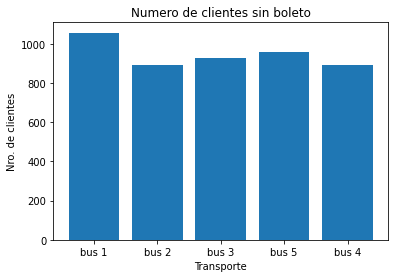

In [ ]:
plt.bar(cliente_total.keys(), cliente_total.values())
plt.title("Numero de clientes sin boleto")
plt.xlabel("Transporte")
plt.ylabel("Nro. de clientes")
plt.show()

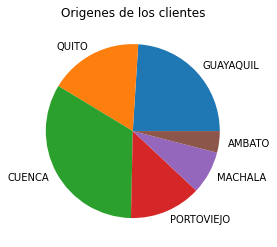

In [ ]:
len_aux =  len(cliente_origen)
y = np.array([(cliente_origen.count('GUAYAQUIL')*100)/len_aux, (cliente_origen.count('QUITO')*100)/len_aux, (cliente_origen.count('CUENCA')*100)/len_aux, (cliente_origen.count('PORTOVIEJO')*100)/len_aux, (cliente_origen.count('MACHALA')*100)/len_aux, (cliente_origen.count('AMBATO')*100)/len_aux])
plt.title("Origenes de los clientes")
plt.pie(y, labels = LUGARES_DESTINO)
plt.show() 

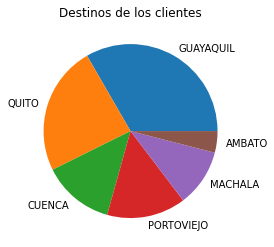

In [ ]:
len_aux =  len(cliente_destino)
y = np.array([(cliente_destino.count('GUAYAQUIL')*100)/len_aux, (cliente_destino.count('QUITO')*100)/len_aux, (cliente_destino.count('CUENCA')*100)/len_aux, (cliente_destino.count('PORTOVIEJO')*100)/len_aux, (cliente_destino.count('MACHALA')*100)/len_aux, (cliente_destino.count('AMBATO')*100)/len_aux])
plt.title("Destinos de los clientes")
plt.pie(y, labels = LUGARES_DESTINO)
plt.show() 

In [ ]:
data_b1={}
data_b2={}
data_b3={}
data_b4={}
data_b5={}

last_aux = -1
for i in bus_uso:
  aux_now = int((i/60)/24)
  if bus_uso[i][0] == 'bus 1' and aux_now > last_aux:
    data_b1[aux_now] = bus_uso[i][1]
    last_aux = aux_now

last_aux = -1
for i in bus_uso:
  aux_now = int((i/60)/24)
  if bus_uso[i][0] == 'bus 2' and aux_now > last_aux:
    data_b2[aux_now] = bus_uso[i][1]
    last_aux = aux_now

last_aux = -1
for i in bus_uso:
  aux_now = int((i/60)/24)
  if bus_uso[i][0] == 'bus 3' and aux_now > last_aux:
    data_b3[aux_now] = bus_uso[i][1]
    last_aux = aux_now

last_aux = -1
for i in bus_uso:
  aux_now = int((i/60)/24)
  if bus_uso[i][0] == 'bus 4' and aux_now > last_aux:
    data_b4[aux_now] = bus_uso[i][1]
    last_aux = aux_now

last_aux = -1
for i in bus_uso:
  aux_now = int((i/60)/24)
  if bus_uso[i][0] == 'bus 5' and aux_now > last_aux:
    data_b5[aux_now] = bus_uso[i][1]
    last_aux = aux_now

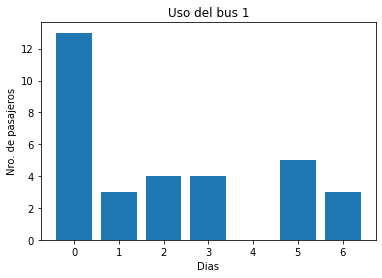

In [ ]:
plt.bar(data_b1.keys(), data_b1.values())
plt.title("Uso del bus 1")
plt.xlabel("Dias")
plt.ylabel("Nro. de pasajeros")
plt.show()

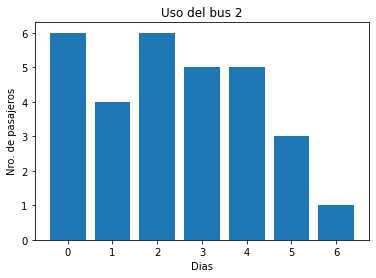

In [ ]:
plt.bar(data_b2.keys(), data_b2.values())
plt.title("Uso del bus 2")
plt.xlabel("Dias")
plt.ylabel("Nro. de pasajeros")
plt.show()

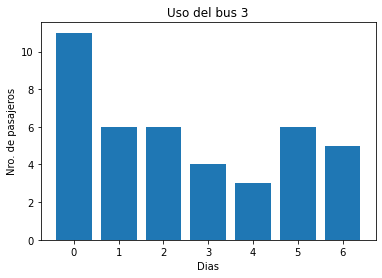

In [ ]:
plt.bar(data_b3.keys(), data_b3.values())
plt.title("Uso del bus 3")
plt.xlabel("Dias")
plt.ylabel("Nro. de pasajeros")
plt.show()

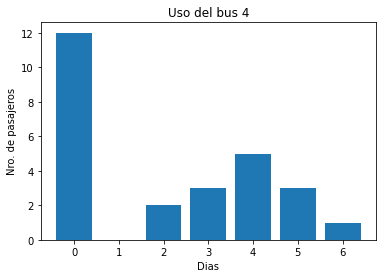

In [ ]:
plt.bar(data_b4.keys(), data_b4.values())
plt.title("Uso del bus 4")
plt.xlabel("Dias")
plt.ylabel("Nro. de pasajeros")
plt.show()

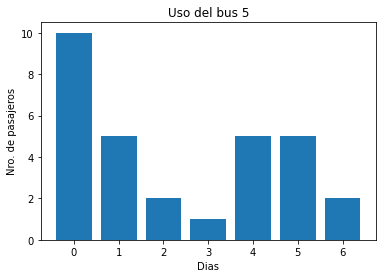

In [ ]:
plt.bar(data_b5.keys(), data_b5.values())
plt.title("Uso del bus 5")
plt.xlabel("Dias")
plt.ylabel("Nro. de pasajeros")
plt.show()

## Conclusiones

Podemos ver que por el modo en el que los buses dejan la estacion cada hora se pierden potenciales clientes que podrían haber subido a uno de los buses. Tenemos incluso casos en los que los buses simplementes dejan la estación sin ningún pasajero. Lo recomendable sería ser más flexible con el horario de los buses y evitar malgastar los recurosos que tenemos. También podemos observar que ningún bus se llena, ni siquiera se acerca a su capacidad máxima. A este punto se recomiendan menos buses que salgan de la estación en un tiempo más razonable.